In [57]:
import kagglehub

path = kagglehub.dataset_download("hoinhi/hc18-split", force_download=True)
path2 = r'C:\Users\dell5515\Desktop\medicine\mlmed2025\lab2\data'
print("Path to dataset files:", path)

import shutil
shutil.move(path, path2)
print('ok')


100%|██████████| 168M/168M [01:13<00:00, 2.38MB/s] 

Extracting files...


Path to dataset files: C:\Users\dell5515\.cache\kagglehub\datasets\hoinhi\hc18-split\versions\1
ok


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K


In [129]:
hc_id = []
paths = []
for dirname,_, filenames in os.walk("/kaggle/input/hc18-split/training_set"):
    for filename in filenames:
        path = os.path.join(dirname,filename)
        paths.append(path)
        
        hc = filename.split(".")[0]
        hc_id.append(hc)

d = {"id": hc_id,"hc_path":paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df

        

,hc_path
id,
245_HC,/kaggle/input/hc18-split/training_set/245_HC.png
531_HC,/kaggle/input/hc18-split/training_set/531_HC.png
557_HC,/kaggle/input/hc18-split/training_set/557_HC.png
442_HC,/kaggle/input/hc18-split/training_set/442_HC.png
073_HC,/kaggle/input/hc18-split/training_set/073_HC.png
...,...
056_HC,/kaggle/input/hc18-split/training_set/056_HC.png
237_3HC,/kaggle/input/hc18-split/training_set/237_3HC.png
315_HC,/kaggle/input/hc18-split/training_set/315_HC.png


In [130]:

hc_id = []
mask_paths = []
for dirname,_, filenames in os.walk("/kaggle/input/hc18-split/training_mask"):
    for filename in filenames:
        path = os.path.join(dirname,filename)
        mask_paths.append(path)

        hc = filename.split(".")[0]
        hc = hc.split("_Annotation")[0]
        hc_id.append(hc)

d = {"id": hc_id,"mask_path":mask_paths}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df

        

,mask_path
id,
492_HC,/kaggle/input/hc18-split/training_mask/492_HC_...
237_2HC,/kaggle/input/hc18-split/training_mask/237_2HC...
244_HC,/kaggle/input/hc18-split/training_mask/244_HC_...
310_HC,/kaggle/input/hc18-split/training_mask/310_HC_...
259_HC,/kaggle/input/hc18-split/training_mask/259_HC_...
...,...
173_HC,/kaggle/input/hc18-split/training_mask/173_HC_...
186_HC,/kaggle/input/hc18-split/training_mask/186_HC_...
051_HC,/kaggle/input/hc18-split/training_mask/051_HC_...


In [ ]:
df["mask_path"] = mask_df["mask_path"]
df


,hc_path,mask_path
id,,
245_HC,/kaggle/input/hc18-split/training_set/245_HC.png,/kaggle/input/hc18-split/training_mask/245_HC_...
531_HC,/kaggle/input/hc18-split/training_set/531_HC.png,/kaggle/input/hc18-split/training_mask/531_HC_...
557_HC,/kaggle/input/hc18-split/training_set/557_HC.png,/kaggle/input/hc18-split/training_mask/557_HC_...
442_HC,/kaggle/input/hc18-split/training_set/442_HC.png,/kaggle/input/hc18-split/training_mask/442_HC_...
073_HC,/kaggle/input/hc18-split/training_set/073_HC.png,/kaggle/input/hc18-split/training_mask/073_HC_...
...,...,...
056_HC,/kaggle/input/hc18-split/training_set/056_HC.png,/kaggle/input/hc18-split/training_mask/056_HC_...
237_3HC,/kaggle/input/hc18-split/training_set/237_3HC.png,/kaggle/input/hc18-split/training_mask/237_3HC...
315_HC,/kaggle/input/hc18-split/training_set/315_HC.png,/kaggle/input/hc18-split/training_mask/315_HC_...


In [ ]:
img_size = (224,224)
def data_augmentation(hc_img,mask):
    if tf.random.uniform(()) > 0.5:
        hc_img = tf.image.flip_left_right(hc_img)
        mask = tf.image.flip_left_right(mask)
    return hc_img, mask
    
def preprocessing(hc_path,mask_path):
    hc_img = tf.io.read_file(hc_path)
    hc_img = tf.image.decode_png(hc_img,channels=3)
    hc_img = tf.image.resize(hc_img,img_size)
    hc_img = tf.cast(hc_img, tf.float32)/ 255.0

    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img,img_size)
    mask_img = tf.math.sign(mask_img)

    return hc_img,mask_img
    
def create_dataset(df,train=False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["hc_path"].values,df["mask_path"].values))
        ds = ds.map(preprocessing,tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["hc_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds


In [ ]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)


In [ ]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000


In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test = valid.batch(BATCH_SIZE)


In [ ]:
def display(display_list):
    plt.figure(figsize=(8,8))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


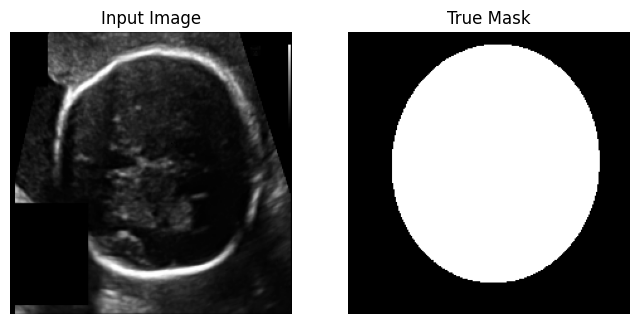

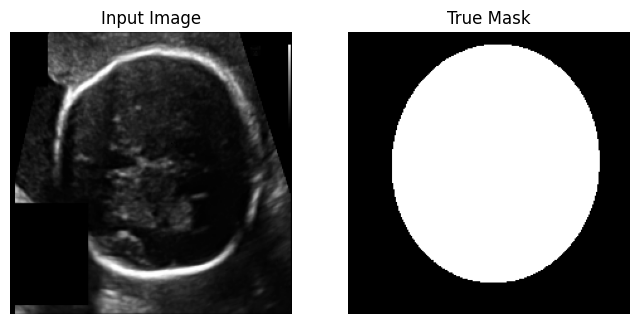

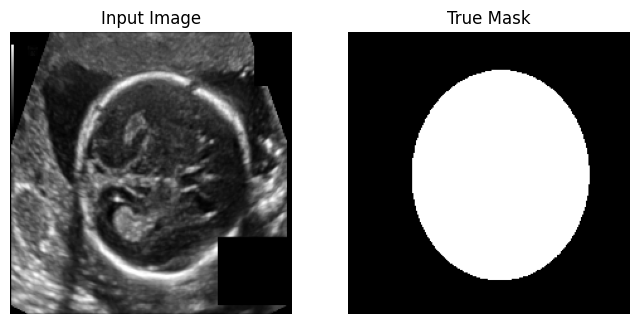

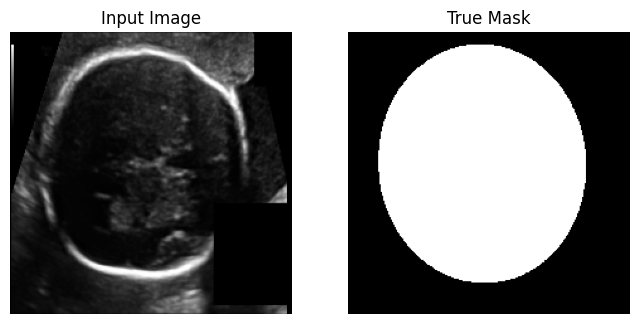

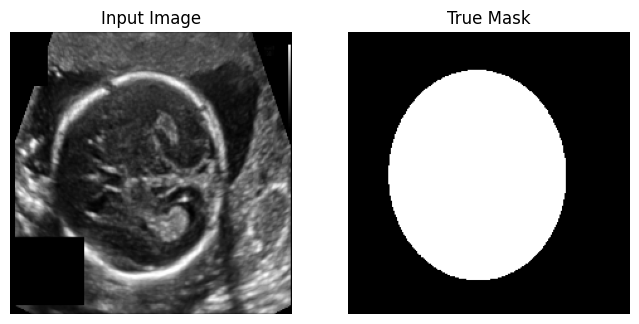

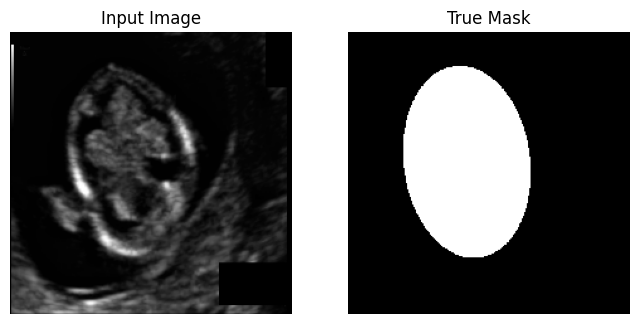

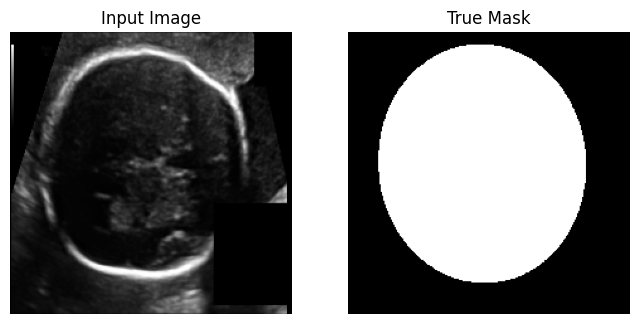

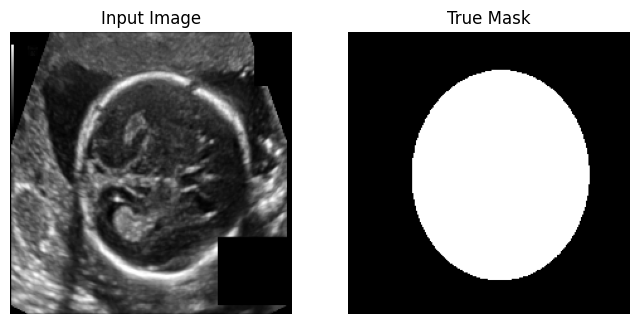

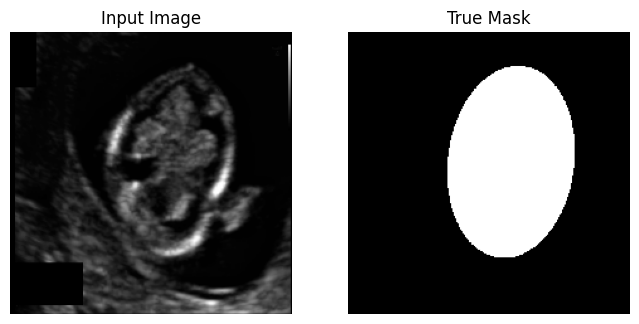

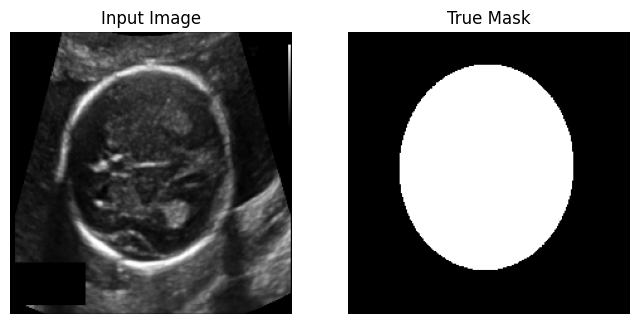

In [ ]:
for i in range(5):
   for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])


## Model 


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False


In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


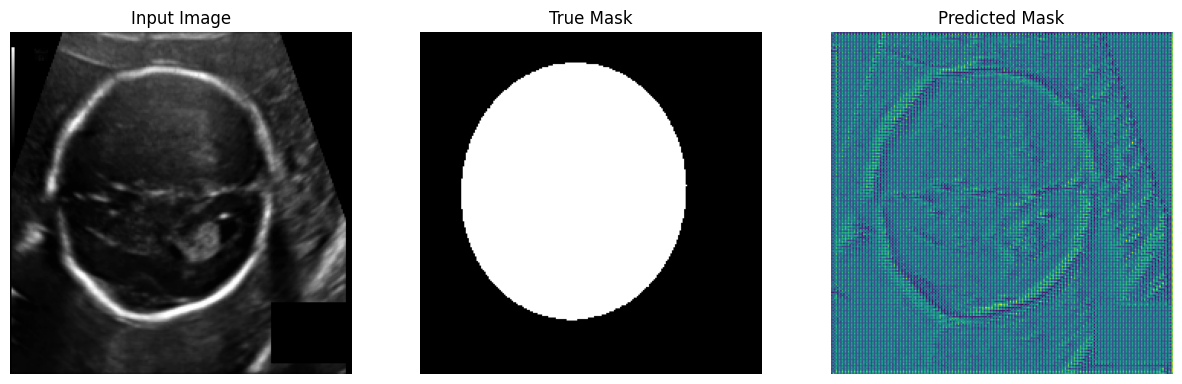

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    
def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)
model = unet_model(1)
model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)


Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - binary_accuracy: 0.9655 - dice_coef: 1.4092 - loss: -0.4092 - val_binary_accuracy: 0.9320 - val_dice_coef: 1.3802 - val_loss: -0.3837
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - binary_accuracy: 0.9683 - dice_coef: 1.4230 - loss: -0.4222 - val_binary_accuracy: 0.9638 - val_dice_coef: 1.4202 - val_loss: -0.4221
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


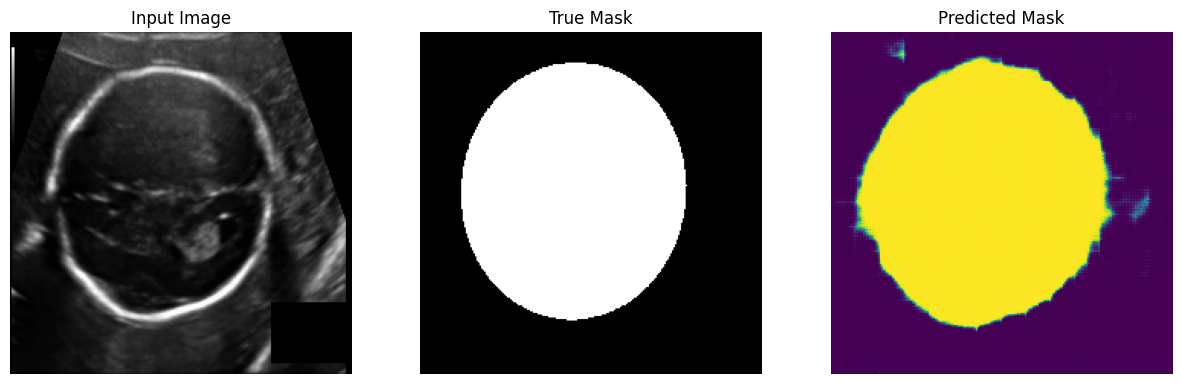

Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - binary_accuracy: 0.9708 - dice_coef: 1.4268 - loss: -0.4274 - val_binary_accuracy: 0.9635 - val_dice_coef: 1.4202 - val_loss: -0.4225
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - binary_accuracy: 0.9693 - dice_coef: 1.4309 - loss: -0.4311 - val_binary_accuracy: 0.9693 - val_dice_coef: 1.4264 - val_loss: -0.4284
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - binary_accuracy: 0.9724 - dice_coef: 1.4382 - loss: -0.4378 - val_binary_accuracy: 0.9309 - val_dice_coef: 1.3750 - val_loss: -0.3789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


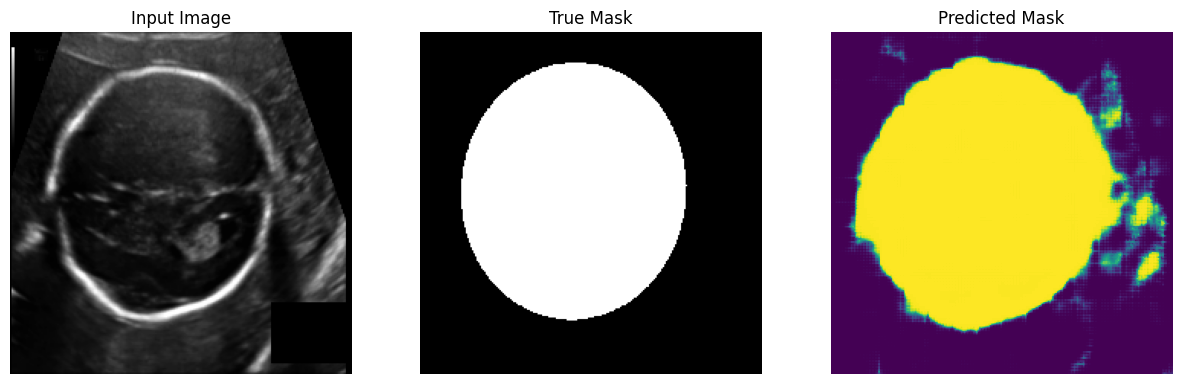

Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - binary_accuracy: 0.9705 - dice_coef: 1.4358 - loss: -0.4357 - val_binary_accuracy: 0.9712 - val_dice_coef: 1.4282 - val_loss: -0.4300
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - binary_accuracy: 0.9745 - dice_coef: 1.4451 - loss: -0.4452 - val_binary_accuracy: 0.9711 - val_dice_coef: 1.4284 - val_loss: -0.4302
Epoch 8/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - binary_accuracy: 0.9738 - dice_coef: 1.4413 - loss: -0.4411 - val_binary_accuracy: 0.9563 - val_dice_coef: 1.4086 - val_loss: -0.4126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


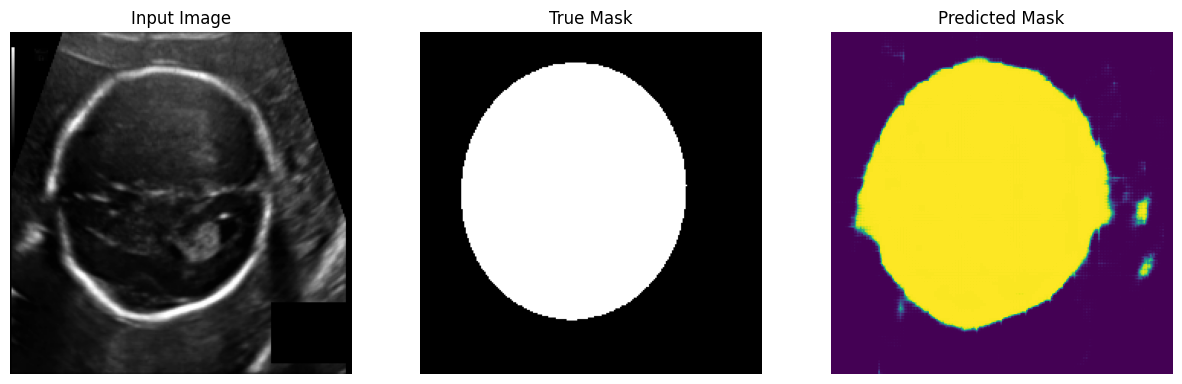

Epoch 9/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - binary_accuracy: 0.9738 - dice_coef: 1.4446 - loss: -0.4453 - val_binary_accuracy: 0.9718 - val_dice_coef: 1.4286 - val_loss: -0.4304
Epoch 10/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - binary_accuracy: 0.9751 - dice_coef: 1.4463 - loss: -0.4465 - val_binary_accuracy: 0.9705 - val_dice_coef: 1.4273 - val_loss: -0.4299
Epoch 11/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - binary_accuracy: 0.9743 - dice_coef: 1.4472 - loss: -0.4470 - val_binary_accuracy: 0.9713 - val_dice_coef: 1.4281 - val_loss: -0.4300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


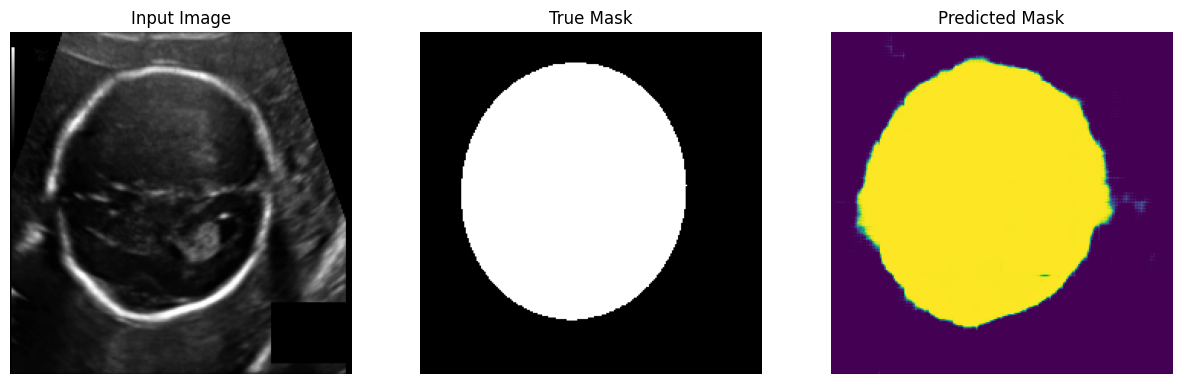

Epoch 12/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - binary_accuracy: 0.9752 - dice_coef: 1.4469 - loss: -0.4469 - val_binary_accuracy: 0.9697 - val_dice_coef: 1.4273 - val_loss: -0.4300
Epoch 13/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - binary_accuracy: 0.9745 - dice_coef: 1.4478 - loss: -0.4479 - val_binary_accuracy: 0.9681 - val_dice_coef: 1.4290 - val_loss: -0.4312
Epoch 14/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - binary_accuracy: 0.9755 - dice_coef: 1.4475 - loss: -0.4477 - val_binary_accuracy: 0.9715 - val_dice_coef: 1.4284 - val_loss: -0.4304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


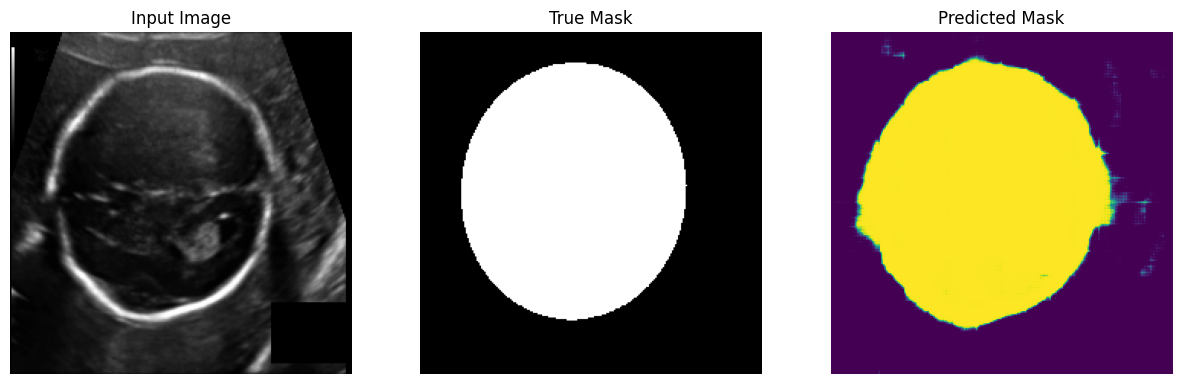

Epoch 15/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - binary_accuracy: 0.9760 - dice_coef: 1.4514 - loss: -0.4514 - val_binary_accuracy: 0.9701 - val_dice_coef: 1.4290 - val_loss: -0.4313


In [145]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 15
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])
